In [116]:
import numpy as np
import matplotlib.pyplot as plt
G = 10

def derivatives(t, y):
    """
    y는 다음 순서로 구성: 
    y = [y1_e, y2_e, y1_g, y2_g, y_1_e, y_2_e, y_1_g, y_2_g]
    """
    y1_e, y2_e, y1_g, y2_g, y_1_e, y_2_e, y_1_g, y_2_g = y
    
    # G_t 값 결정 (t=0 일 때만 G, 이후로는 0)
    if t < 1e-4:
        Gval = G
    else:
        Gval = 0.0  
        
    # 미분방정식에 따라 dy/dt 계
    dy1_e = Gval * y1_g - kr1 * y1_e - k12 * y1_e * y2_g - k11 * y1_e * y_1_g - k12 * y1_e * y_2_g + k11 * y_1_e * y1_g
    dy2_e = Gval * y2_g - kr1 * y2_e + k12 * y1_e * y2_g - k22 * y2_e * y_2_g + k12 * y_1_e * y2_g + k22 * y_2_e * y2_g
    dy1_g = -dy1_e
    dy2_g = -dy2_e

    dy_1_e = Gval * y_1_g - (kr1 + kn1) * y_1_e + k11 * y1_e * y_1_g - k12 * y_1_e * y2_g - k11 * y_1_e * y1_g - k12 * y_1_e * y_2_g ##
    dy_2_e = Gval * y_2_g - (kr1 + kn1) * y_2_e + k12 * y1_e * y_2_g + k22 * y2_e * y_2_g + k12* y_1_e * y_2_g - k22 * y_2_e * y2_g
    dy_1_g = -dy_1_e
    dy_2_g = -dy_2_e
    
    return [dy1_e, dy2_e, dy1_g, dy2_g, dy_1_e, dy_2_e, dy_1_g, dy_2_g]

def derivatives_vectorized(t, y, params_vec, G_val):
    # Extract parameters
    q, m, kr1, k12, k11, k22, kn1, mix = params_vec.T
    
    # Extract state variables for all parameter sets
    # y = [y1_e, y2_e, y1_g, y2_g, y_1_e, y_2_e, y_1_g, y_2_g]
    y1_e, y2_e, y1_g, y2_g, y_1_e, y_2_e, y_1_g, y_2_g = y.T
    
    # G_t value determination (G only when t < 1e-4, otherwise 0)
    if t < 1e-4:
        Gval = G_val
    else:
        Gval = 0.0
    
    # Calculate derivatives for all parameter sets simultaneously
    dy1_e = (Gval * y1_g - kr1 * y1_e - k12 * y1_e * y2_g - k11 * y1_e * y_1_g - k12 * y1_e * y_2_g + k11 * y_1_e * y1_g)
    dy2_e = (Gval * y2_g - kr1 * y2_e + k12 * y1_e * y2_g - k22 * y2_e * y_2_g + k12 * y_1_e * y2_g + k22 * y_2_e * y2_g)
    
    dy1_g = -dy1_e
    dy2_g = -dy2_e
    
    dy_1_e = (Gval * y_1_g - (kr1 + kn1) * y_1_e + k11 * y1_e * y_1_g - k12 * y_1_e * y2_g - k11 * y_1_e * y1_g - k12 * y_1_e * y_2_g)
    dy_2_e = (Gval * y_2_g - (kr1 + kn1) * y_2_e + k12 * y1_e * y_2_g + k22 * y2_e * y_2_g + k12 * y_1_e * y_2_g - k22 * y_2_e * y2_g)
    
    dy_1_g = -dy_1_e
    dy_2_g = -dy_2_e
    
    # Stack derivatives
    dydt = np.column_stack([dy1_e, dy2_e, dy1_g, dy2_g, dy_1_e, dy_2_e, dy_1_g, dy_2_g])
    return dydt

In [117]:
def runge_kutta_vectorized(params, t_span, dt=0.01):
    n_params = params.shape[0]
    
    # Extract parameters for all sets at once
    q = params[:, 0]    # shape: (n,)
    m = params[:, 1]    # shape: (n,)
    kr1 = params[:, 2]  # shape: (n,)
    k12 = params[:, 3]  # shape: (n,)
    k11 = params[:, 4]  # shape: (n,)
    k22 = params[:, 5]  # shape: (n,)
    kn1 = params[:, 6]  # shape: (n,)
    mix = params[:, 7]  # shape: (n,)
    
    # Time setup
    t_start, t_end = t_span
    t = np.arange(t_start, t_end + dt, dt)
    n_steps = len(t)
    
    # Initial conditions for all parameter sets
    # y_init shape: (n, 8) - each row is initial state for one parameter set
    y_init = np.zeros((n_params, 8))
    y_init[:, 2] = m * (1.0 - q)           # state 2
    y_init[:, 3] = (1.0 - m) * (1.0 - q)   # state 3
    y_init[:, 6] = m * q                   # state 6
    y_init[:, 7] = (1.0 - m) * q           # state 7
    
    # Solution array: (n_params, n_steps, 8)
    y_all = np.zeros((n_params, n_steps, 8))
    y_all[:, 0, :] = y_init
    
    # Current state for all parameter sets
    y_current = y_init.copy()  # shape: (n_params, 8)
    
    for i in range(1, n_steps):
        t_current = t[i-1]
        
        k1 = dt * derivatives_vectorized(t_current, y_current, params, G)
        k2 = dt * derivatives_vectorized(t_current + dt/2, y_current + k1/2, params, G)
        k3 = dt * derivatives_vectorized(t_current + dt/2, y_current + k2/2, params, G)
        k4 = dt * derivatives_vectorized(t_current + dt, y_current + k3, params, G)
        
        # Update state for all parameter sets
        y_current = y_current + (k1 + 2*k2 + 2*k3 + k4) / 6
        y_all[:, i, :] = y_current
    
    sim_y1 = mix[:, None] * (y_all[:, :, 0] + y_all[:, :, 4]) + (1 - mix[:, None]) * (y_all[:, :, 1] + y_all[:, :, 5])
    sim_y2 = y_all[:, :, 1] + y_all[:, :, 5]

    sim_y1_max = np.max(sim_y1, axis= 1)
    sim_y2_max = np.max(sim_y2, axis= 1)

    sim_y1 = sim_y1 / (sim_y1_max[:, None])
    sim_y2 = sim_y2 / (sim_y2_max[:, None])
    
    return t, y_all, sim_y1, sim_y2

In [118]:
def MSE(y1_measured, y2_measured, y1_simul, y2_simul):
    out_mse = np.mean(np.abs((y1_measured - y1_simul)) + np.abs((y2_measured - y2_simul)), axis = 1)
    return out_mse

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import nbformat
import os
from scipy.interpolate import interp1d

# ====================================
# 1. 데이터 로드 및 초기 조건 계산
# ====================================
def load_experiment_data(file_path):
    """
    파일 경로에 있는 데이터를 로드합니다.
    쉼표 또는 공백 구분자를 지원하며, 시간과 값을 반환합니다.
    """
    try:
        data = np.loadtxt(file_path, delimiter=',')
    except ValueError:
        data = np.loadtxt(file_path)
    return data[:, 0], data[:, 1]

# 데이터 파일 경로 (파일이 있는 경로에 맞게 수정)
t_data, y1_e_measured = load_experiment_data('y1_data.txt')
______, y2_e_measured = load_experiment_data('y2_data.txt')
t_data = np.array(t_data, dtype=np.float64) * np.float64(1e6)

In [128]:
import numpy as np
import random

for epoch in range(1):
    print('epoch:', epoch)
    
    # PSO 하이퍼파라미터
    num_particles = 200
    num_iterations = 1000
    w = np.float64(0.7)
    c1 = np.float64(1.5)
    c2 = np.float64(1.5)

    dim = 8                #  q    m          kr1   k12      k11    k22    kn1    n1

    lower_bounds = np.array([0.10, 0.10,   0.0,    0.0,     0.0,    0.0,   0.0,    0.10], dtype=np.float64)
    upper_bounds = np.array([1.00, 1.00,    30,     30,      30,     30,    30,    1.00], dtype=np.float64)
    
    velocity_clamp = np.float64(1.0) * (upper_bounds - lower_bounds)

    # 초기화
    positions = np.random.uniform(low=lower_bounds, high=upper_bounds, size=(num_particles, dim)).astype(np.float64)
    velocities = np.random.uniform(low=-velocity_clamp, high=velocity_clamp, size=(num_particles, dim)).astype(np.float64)
    personal_best_positions = np.copy(positions).astype(np.float64)
    personal_best_scores = np.full(num_particles, np.inf, dtype=np.float64)
    
    # 초기 평가
    _, _, init_sim_y1, init_sim_y2 = runge_kutta_vectorized(positions, (0, 1.45), dt=0.01)
    scores = MSE(y1_e_measured, y2_e_measured, init_sim_y1, init_sim_y2)
    personal_best_scores = scores
    personal_best_positions = np.copy(positions)
    
    # 전역 최적
    global_best_index = np.argmin(personal_best_scores)
    global_best_position = personal_best_positions[global_best_index].astype(np.float64)
    global_best_score = personal_best_scores[global_best_index]
    
    # PSO 루프
    for iter in range(num_iterations):
        r1 = np.random.rand(num_particles, dim).astype(np.float64)
        r2 = np.random.rand(num_particles, dim).astype(np.float64)

        # 속도 업데이트
        velocities = (
            w * velocities +
            c1 * r1 * (personal_best_positions - positions) +
            c2 * r2 * (global_best_position - positions)
        ).astype(np.float64)

        # 속도 제한
        velocities = np.clip(velocities, -velocity_clamp, velocity_clamp).astype(np.float64)

        # 위치 업데이트
        positions = (positions + velocities).astype(np.float64)
        positions = np.clip(positions, lower_bounds, upper_bounds).astype(np.float64)

        # 새로운 평가
        _, new_y_all, new_sim_y1, new_sim_y2 = runge_kutta_vectorized(positions, (0, 1.45), dt=0.01)
        scores = MSE(y1_e_measured, y2_e_measured, new_sim_y1, new_sim_y2)
        
        # 개인 최적 갱신
        better_mask = scores < personal_best_scores
        personal_best_scores[better_mask] = scores[better_mask]
        personal_best_positions[better_mask] = positions[better_mask]
        
        # 전역 최적 갱신
        min_index = np.argmin(personal_best_scores)
        if personal_best_scores[min_index] < global_best_score:
            global_best_score = personal_best_scores[min_index]
            global_best_position = personal_best_positions[min_index]
            global_best_y1 = new_sim_y1[min_index]
            global_best_y2 = new_sim_y2[min_index]
            global_best_y_all = new_y_all[min_index]
            
        if (iter+1) % 50 == 0: 
            print(f"Iteration {iter+1}/{num_iterations} - Best Score: {global_best_score:.15f}")

epoch: 0
Iteration 50/1000 - Best Score: 0.024905162596032
Iteration 100/1000 - Best Score: 0.024887367447285
Iteration 150/1000 - Best Score: 0.024853065962877
Iteration 200/1000 - Best Score: 0.024834396381979
Iteration 250/1000 - Best Score: 0.024828574292952
Iteration 300/1000 - Best Score: 0.024827770284364
Iteration 350/1000 - Best Score: 0.024827131093916
Iteration 400/1000 - Best Score: 0.024827025362355
Iteration 450/1000 - Best Score: 0.024826883731252
Iteration 500/1000 - Best Score: 0.024826826016838
Iteration 550/1000 - Best Score: 0.024826726095555
Iteration 600/1000 - Best Score: 0.024826625223040
Iteration 650/1000 - Best Score: 0.024826593002377
Iteration 700/1000 - Best Score: 0.024826577133308
Iteration 750/1000 - Best Score: 0.024826463790495
Iteration 800/1000 - Best Score: 0.024826354026901
Iteration 850/1000 - Best Score: 0.024826321077665
Iteration 900/1000 - Best Score: 0.024826311250360
Iteration 950/1000 - Best Score: 0.024826308094560
Iteration 1000/1000 - B

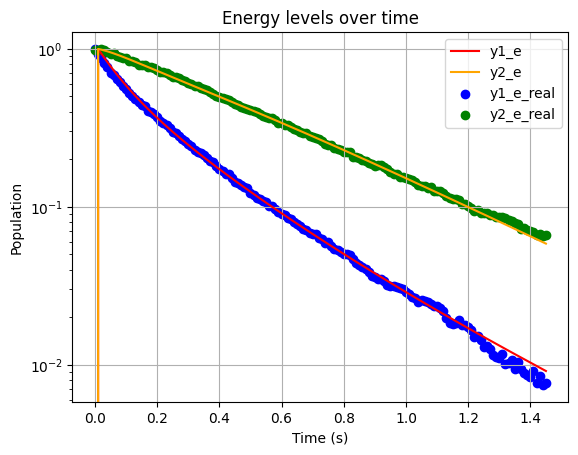

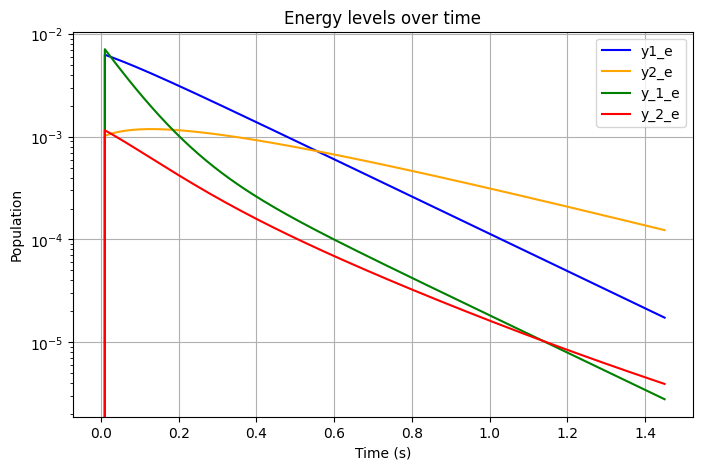

0.0062870559115455115 1.7311616277101034e-05
0.0010196924017468413 0.00012320553249002558
0.007115305967051892 2.7793284622885883e-06
0.0011558979594051817 3.9168025090639705e-06
q_fixed = 0.5523057720011564
m_fixed = 0.8681048093877224
kr1_fixed = 2.029172550674149
k12_fixed = 7.169904038538368
k11_fixed = 2.8900803328190223
k22_fixed = 2.2983316286548257
kn1_fixed = 8.713242334598982
n1_fixed = 0.5124291885646389
global_best_score: 0.024826307890628323


In [129]:
q= global_best_position[0]
m= global_best_position[1]
kr1= global_best_position[2]
k12= global_best_position[3]
k11= global_best_position[4]
k22= global_best_position[5]
kn1= global_best_position[6]
mix = global_best_position[7]

sim_y1 = global_best_y1
sim_y2 = global_best_y2

plt.plot(t_data, sim_y1, label='y1_e', c= 'r')
plt.plot(t_data, sim_y2, label='y2_e', c= 'orange')

y1_e_measured = y1_e_measured
y2_e_measured = y2_e_measured

plt.scatter(t_data, y1_e_measured, label='y1_e_real', c= 'b')
plt.scatter(t_data, y2_e_measured, label='y2_e_real', c= 'g')

plt.title("Energy levels over time")
plt.xlabel("Time (s)")
plt.ylabel("Population")
plt.legend()
plt.grid(True)
plt.yscale('log')  # <-- y축을 로그 스케일로 설정
plt.savefig("100.png")
plt.show()


plt.figure(figsize=(8,5))


sim_y1 = global_best_y_all[:, 0]
sim_y2 = global_best_y_all[:, 1]
sim_y3 = global_best_y_all[:, 4]
sim_y4 = global_best_y_all[:, 5]

plt.plot(t_data, sim_y1, label='y1_e', c= 'b')
plt.plot(t_data, sim_y2, label='y2_e', c= 'orange')
plt.plot(t_data, sim_y3, label='y_1_e', c= 'g')
plt.plot(t_data, sim_y4, label='y_2_e', c= 'r')

"""plt.plot(times, sim_y5, label='y1_e', c= 'b')
plt.plot(times, sim_y6, label='y2_e', c= 'orange')
plt.plot(times, sim_y7, label='y_1_e', c= 'g')
plt.plot(times, sim_y8, label='y_2_e', c= 'r')"""

plt.title("Energy levels over time")
plt.xlabel("Time (s)")
plt.ylabel("Population")
plt.legend()
plt.grid(True)
plt.yscale('log')  # <-- y축을 로그 스케일로 설정
plt.savefig("101.png")
plt.show()


Ini_bound_y1 = global_best_y_all[1, 0]
Ini_bound_y2 = global_best_y_all[1, 1]
Ini_bound_y3 = global_best_y_all[1, 4]
Ini_bound_y4 = global_best_y_all[1, 5]

Term_bound_y1 = global_best_y_all[-1, 0]
Term_bound_y2 = global_best_y_all[-1, 1]
Term_bound_y3 = global_best_y_all[-1, 4]
Term_bound_y4 = global_best_y_all[-1, 5]

print(Ini_bound_y1,Term_bound_y1)
print(Ini_bound_y2,Term_bound_y2)
print(Ini_bound_y3,Term_bound_y3)
print(Ini_bound_y4,Term_bound_y4)


print('q_fixed =', q)
print('m_fixed =', m)

print('kr1_fixed =', kr1)
print('k12_fixed =', k12)
print('k11_fixed =', k11)
print('k22_fixed =', k22)
print('kn1_fixed =', kn1)
print('n1_fixed =', mix)
print("global_best_score:", global_best_score)